# SHAP (Feature Selection)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


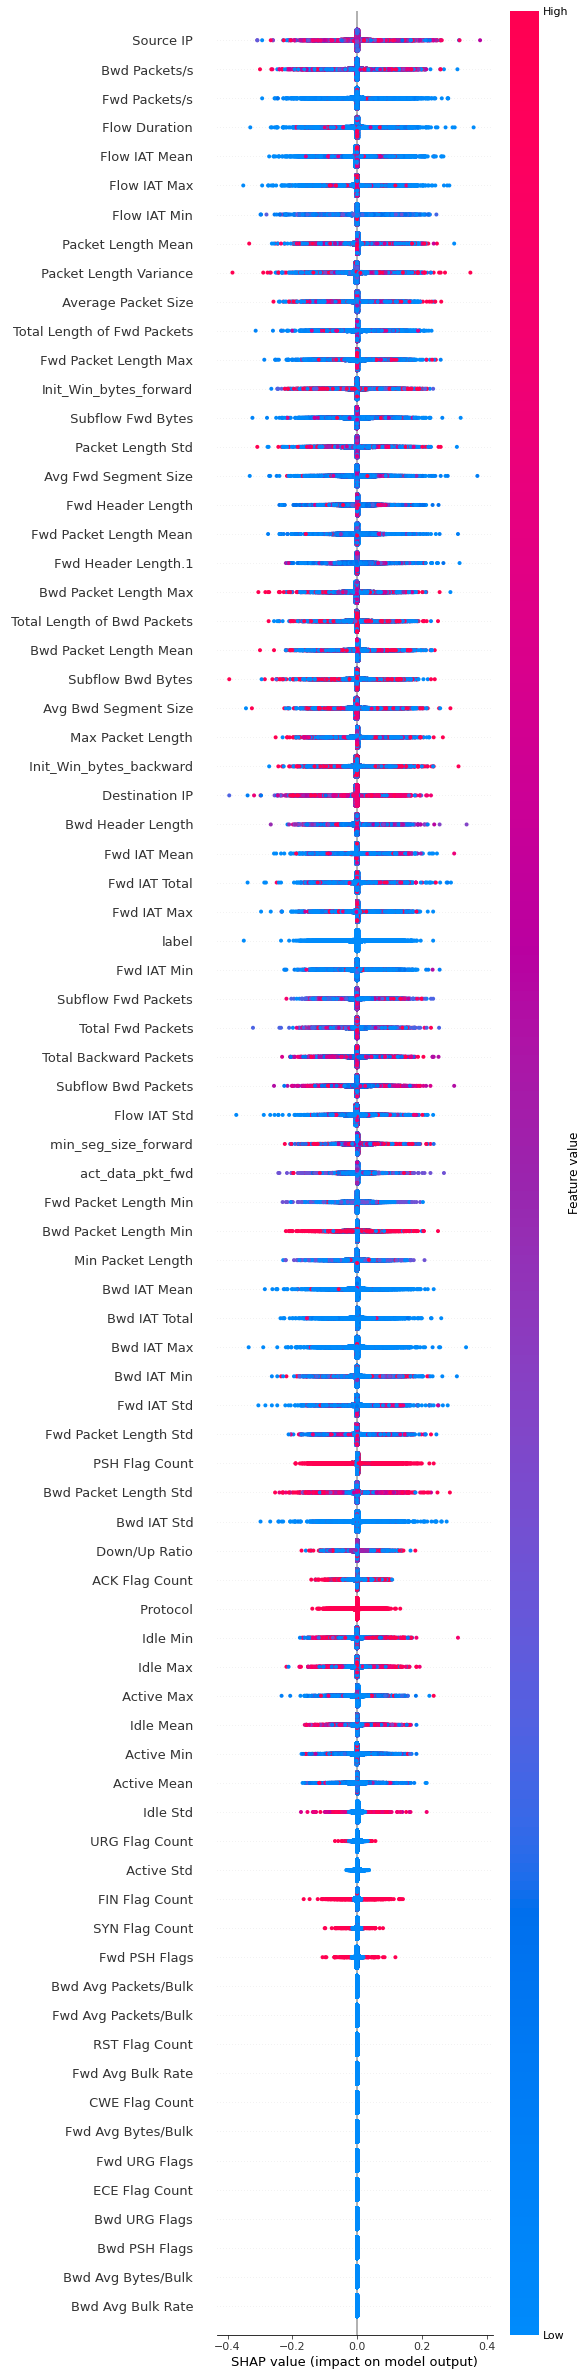

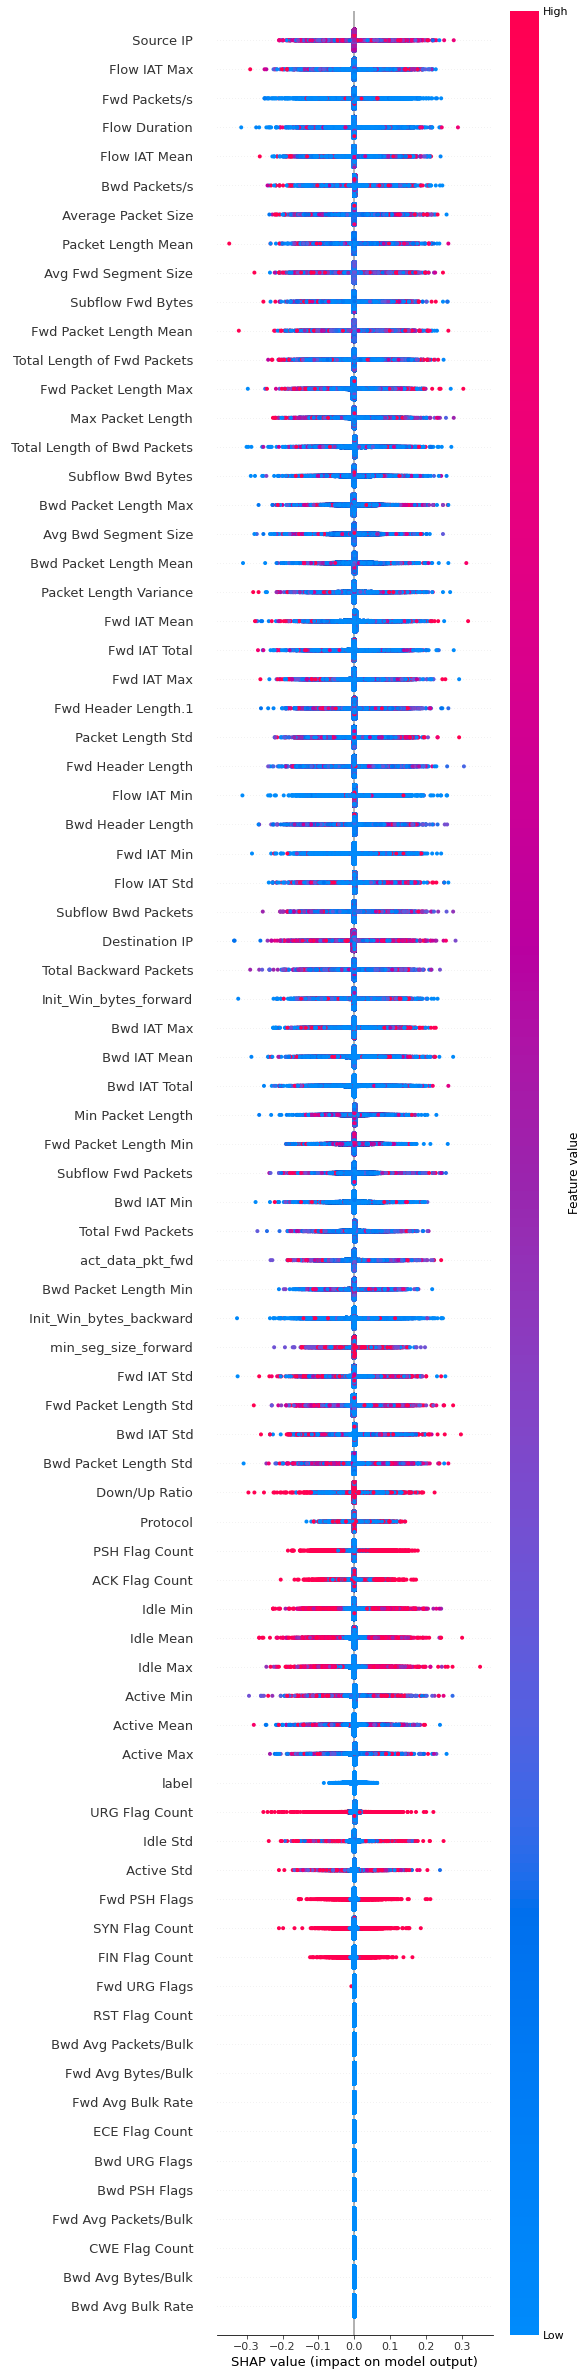

In [1]:
import pandas as pd
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np


X_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_all.csv', encoding="ISO-8859–1", dtype = str)
X_test = X_test.apply(pd.to_numeric)
X_test = X_test.astype(float)

# print(X_test.dtypes.to_string())


# filename_expl = './src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer.sav'
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_shapvalues_all.sav'


# load_explainer = pickle.load(open(filename_expl, 'rb'))
# print(load_explainer)

label_column = X_test["label"]
attack_indx = []
benign_indx = []
for i, x in enumerate(label_column):
    if (x == 1.0):
        attack_indx.append(i)
    elif (x == 0.0):
        benign_indx.append(i)

load_shap_values = pickle.load(open(filename, 'rb'))

shap.summary_plot(load_shap_values[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])

In [2]:
# Feature importance
print("Avg shapley values for intrusions :")
print(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0) / len(attack_indx))
print()
feature_order_attack = np.argsort(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0))
feature_order_attack = [X_test.columns[i] for i in feature_order_attack][::-1]
print(feature_order_attack)

print()
print("**********")
print()

print("Avg shapley values for bengin :")
print(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0) / len(benign_indx))
print()
feature_order_benign = np.argsort(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0))
feature_order_benign = [X_test.columns[i] for i in feature_order_benign][::-1]
print(feature_order_benign)

Avg shapley values for intrusions :
[0.01087603 0.01526609 0.01540351 0.00761305 0.01069569 0.01579855
 0.01591626 0.01632101 0.01373181 0.01705698 0.01035427 0.01199902
 0.         0.01213003 0.0168008  0.01650997 0.00148333 0.00751466
 0.00815115 0.         0.01576221 0.0117672  0.01370348 0.00237694
 0.00776591 0.0031143  0.         0.01227532 0.01436392 0.01448252
 0.01381666 0.01382443 0.01448396 0.01485565 0.00765582 0.00772055
 0.00267912 0.01564485 0.01027848 0.01685333 0.         0.00791185
 0.         0.0153588  0.         0.01526564 0.00193992 0.0157396
 0.01541506 0.01614177 0.01505611 0.01638714 0.         0.01382881
 0.00863148 0.         0.01180927 0.         0.01294611 0.01580916
 0.01209592 0.01787909 0.01642573 0.01500383 0.01561298 0.01657834
 0.00147636 0.01151187 0.         0.01577142 0.         0.
 0.00746472 0.01277955 0.01524886 0.01244471 0.01206176 0.01559366
 0.01384499]

[' Source IP', ' Bwd Packets/s', 'Fwd Packets/s', ' Flow Duration', ' Flow IAT Mean', ' 

# Feature Selection

In [3]:
feature_selection_rate = 0.8

important_features = ['label', ' Source IP', ' Destination IP']
feature_order_attack = [x for x in feature_order_attack if x not in important_features]
feature_order_benign = [x for x in feature_order_benign if x not in important_features]

least_important_in_attack = feature_order_attack[int(feature_selection_rate * 76):]
least_important_in_benign = feature_order_benign[int(feature_selection_rate * 76):]

least_important = list(set(least_important_in_attack) & set(least_important_in_benign))

print(least_important)
print()
print("len(least_important) =", len(least_important))

sizeh = 76 - len(least_important)
print("sizeh =", sizeh)

[' Active Std', ' ECE Flag Count', ' Fwd Avg Packets/Bulk', ' RST Flag Count', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', 'Bwd Avg Bulk Rate', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' SYN Flag Count', ' CWE Flag Count', 'Fwd PSH Flags', ' Bwd Avg Bytes/Bulk', 'FIN Flag Count']

len(least_important) = 16
sizeh = 60


# E-GraphSAGE

In [13]:
from dgl import from_networkx
import sklearn
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import numpy as np
from sklearn.metrics import confusion_matrix

import os
from sklearn.utils import shuffle

from dgl.data.utils import save_graphs

import shap
import matplotlib.pyplot as plt

#constante
size_embedding = 152
nb_batch = 5

# Accuracy --------------------------------------------------------------------
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()
# -----------------------------------------------------------------------------

# ------------------------------------------ Model Architecture -----------------------------------------------------------------

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        x = th.cat([edges.src['h'], edges.data['h']], 2)
        y = self.W_msg(x)
        return {'m': y}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Line 4 of algorithm 1 : update all because we are using a full neighborhood sampling and not a k-hop neigh sampling
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Line 5 of algorithm 1
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, size_embedding, activation))
        self.layers.append(SAGELayer(size_embedding, edim, size_embedding, activation)) ##
        self.layers.append(SAGELayer(size_embedding, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):

        for i, layer in enumerate(self.layers):
            #nf = 'weights'+str(i)+'.txt'
            #sourceFile = open(nf, 'w')
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)
        # Return a list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        v = th.cat([h_u, h_v], 1)
        score = self.W(v)
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            # Update the features of the specified edges by the provided function
            # DGLGraph.apply_edges(func, edges='__ALL__', etype=None, inplace=False)
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class GPreprocessing():
    def __init__(self):
        self.encoder_cols = [x for x in [' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'] if x not in least_important]
        if (len(self.encoder_cols) != 0):
            self.encoder1 = ce.TargetEncoder(cols = self.encoder_cols)
        self.scaler1 = StandardScaler()
        super().__init__()

    def train(self, data1):
        # Preprocessing and creation of the h attribute
        label1 = data1['label']
        if (len(self.encoder_cols) != 0):
            self.encoder1.fit(data1, label1)
            data1 = self.encoder1.transform(data1)
        # scaler (normalization)
        # Manipulate flow content (all columns except : label, Source IP & Destination IP)
        cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
        data1[cols_to_norm1] = self.scaler1.fit_transform(data1[cols_to_norm1])
        ## Create the h attribute that will contain the content of our flows
        data1['h'] = data1[ cols_to_norm1 ].values.tolist()
        # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
        data1.drop(columns = cols_to_norm1, inplace = True)
        # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
        data1 = data1.reindex(columns=columns_titles)

        # Graph construction #################################################
        G1 = nx.from_pandas_edgelist(data1, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiDiGraph())
        # G1 = G1.to_directed()
        G1 = from_networkx(G1,edge_attrs=['h','label'] )
        G1.ndata['h'] = th.ones(G1.num_nodes(), G1.edata['h'].shape[1])
        G1.edata['train_mask'] = th.ones(len(G1.edata['h']), dtype=th.bool)
        G1.ndata['h'] = th.reshape(G1.ndata['h'], (G1.ndata['h'].shape[0], 1, G1.ndata['h'].shape[1]))
        G1.edata['h'] = th.reshape(G1.edata['h'], (G1.edata['h'].shape[0], 1, G1.edata['h'].shape[1]))
        return G1

    def test(self, data1):
        if (len(self.encoder_cols) != 0):
            data1 = self.encoder1.transform(data1)
        cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
        data1[cols_to_norm1] = self.scaler1.transform(data1[cols_to_norm1])
        data1['h'] = data1[ cols_to_norm1 ].values.tolist()
        data1.drop(columns = cols_to_norm1, inplace = True)
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
        data1 = data1.reindex(columns=columns_titles)

        # Graph construction #################################################
        G1_test = nx.from_pandas_edgelist(data1, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiDiGraph())
        # G1_test = G1_test.to_directed()
        G1_test = from_networkx(G1_test,edge_attrs=['h','label'] )
        # G1.ndata['h'].shape[2] = sizeh = 76
        G1_test.ndata['feature'] = th.ones(G1_test.num_nodes(), sizeh)
        G1_test.ndata['feature'] = th.reshape(G1_test.ndata['feature'], (G1_test.ndata['feature'].shape[0], 1, G1_test.ndata['feature'].shape[1]))
        G1_test.edata['h'] = th.reshape(G1_test.edata['h'], (G1_test.edata['h'].shape[0], 1, G1_test.edata['h'].shape[1]))
        return G1_test


class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.preprocessing = GPreprocessing()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, nbclasses)

    def train(self, data1, epochs):
        G1 = self.preprocessing.train(data1)
        G1 = G1.to('cuda:0')
        from sklearn.utils import class_weight
        class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1.edata['label'].cpu().numpy()),
                                                        y = G1.edata['label'].cpu().numpy())
        class_weights1 = th.FloatTensor(class_weights1).cuda()
        criterion1 = nn.CrossEntropyLoss(weight = class_weights1)

        nfeats = G1.ndata['h']
        efeats = G1.edata['h']

        edge_label1 = G1.edata['label']
        train_mask1 = G1.edata['train_mask']

        for epoch in range(1, epochs):
            h = self.gnn(G1, nfeats, efeats).cuda()
            pred1 = self.pred(G1, h).cuda()
            loss = criterion1(pred1[train_mask1], edge_label1[train_mask1])
            opt.zero_grad()
            loss.backward()
            opt.step()
            # if epoch % 10 == 0:
            #     print('Training acc:', compute_accuracy(pred1[train_mask1], edge_label1[train_mask1]), loss)

        h = self.gnn(G1, nfeats, efeats).cuda()
        pred1 = self.pred(G1, h).cuda()

        pred1 = pred1.argmax(1)
        pred1 = th.Tensor.cpu(pred1).detach().numpy()
        edge_label1 = th.Tensor.cpu(edge_label1).detach().numpy()
        return pred1, edge_label1

    def predict(self, data1):
        G1_test = self.preprocessing.test(data1)
        G1_test = G1_test.to('cuda:0')
        actual1 = G1_test.edata.pop('label')
        node_features_test1 = G1_test.ndata['feature']
        edge_features_test1 = G1_test.edata['h']
        h = self.gnn(G1_test, node_features_test1, edge_features_test1).cuda()
        test_pred1 = self.pred(G1_test, h)

        test_pred1 = test_pred1.argmax(1)
        test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()
        actual1 = th.Tensor.cpu(actual1).detach().numpy()
        return test_pred1, actual1

    def xai_predict(self, data1):
        G1_test = self.preprocessing.test(data1)
        G1_test = G1_test.to('cuda:0')
        node_features_test1 = G1_test.ndata['feature']
        edge_features_test1 = G1_test.edata['h']
        h = self.gnn(G1_test, node_features_test1, edge_features_test1).cuda()
        test_pred1 = self.pred(G1_test, h)

        test_pred1 = test_pred1.argmax(1)
        test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()
        return test_pred1

    # def forward(self, g, nfeats, efeats):
        # h = self.gnn(g, nfeats, efeats)
        # # h = list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
        # return self.pred(g, h)

# -------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------- MAIN -----------------------------------------------------------

#Data
nbclasses =  2


# Model *******************************************************************************************
# G1.ndata['h'].shape[2] = sizeh = 76 dans ANIDS
# model1 = Model(G1.ndata['h'].shape[2], size_embedding, G1.ndata['h'].shape[2], F.relu, 0.2).cuda()

print("sizeh =", sizeh)

model1 = Model(sizeh, size_embedding, sizeh, F.relu, 0.2).cuda()
opt = th.optim.Adam(model1.parameters())


path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)

for nb_files in range(1):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)

    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')
    print("nb total instances in the file : ", len(data1.values))

    print("++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++")

    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]
    
    # Feature Selection +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    cols = list(set(list(data1.columns )) - set(least_important))
    data1 = data1[cols]
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Source Port'] = data1[' Source Port'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)
    data1[' Destination Port'] = data1[' Destination Port'].apply(str)
    data1[' Source IP'] = data1[' Source IP'] + ':' + data1[' Source Port']
    data1[' Destination IP'] = data1[' Destination IP'] + ':' + data1[' Destination Port']

    data1.drop(columns=['Flow ID',' Source Port',' Destination Port',' Timestamp'], inplace=True)

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]

    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)

    ##################### LABELS FREQ #######################################
    print()
    print("labels freq after changing labels to binary")
    counts = list(data1[' Label'].value_counts().to_dict().items())
    for j, x in enumerate(counts):
        x = list(x)
        x[1] = x[1] / len(data1)
        counts[j] = x
    print({f'{files[nb_files]}' : counts})
    ##############################################################################

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale

    # split train and test
    data1 =  pd.concat([data1, label1], axis=1) # ??????? WHY ?

    # -------------------- ????????????????????????????????????????? --------------------
    # X will contain the label column due to the concatination made earlier !!
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    # At this step we duplicated the least populated classes in the Train Set
    # 2nd step : Create the mini batches
    a = b = mean_macro_f1 = 0
    for batch in range(1, nb_batch + 1):
        print(f"+++++++++++++++++ Batch {batch} ++++++++++++++++")
        a = b
        b = int(len(X1_train) / nb_batch) * batch
        if batch == nb_batch :
            b = len(X1_train)
        # The batch :
        X1_train_batched = X1_train.iloc[a:b]
        y1_train_batched = X1_train_batched['label']

        pred1, edge_label1 = model1.train(X1_train_batched, 1)

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1, pred1))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1, pred1, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1, pred1, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1, pred1, labels=[0,1]))

    # ------------------------------------------------ Test ---------------------------------------------------------------------
    print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
    print("nb Test instances : ", len(X1_test.values))

    test_pred1, actual1 = model1.predict(X1_test)
    print(test_pred1)
    print(len(test_pred1))
    print(len(actual1))

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
    print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

sizeh = 60
CIC-IDS-2017-Dataset4.csv ++++++++++++++++++++++++++++++++++++++++++++++
nb total instances in the file :  460167
++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++

labels freq after changing labels to binary
{'CIC-IDS-2017-Dataset4.csv': [[0, 0.7582073464633492], [1, 0.24179265353665083]]}
+++++++++++++++++ Batch 1 ++++++++++++++++
Train metrics :
Accuracy :  0.7551340359809385
Precision :  0.23676880222841226
Recall :  0.0054536122160913645
f1_score :  0.01066164941988084
+++++++++++++++++ Batch 2 ++++++++++++++++
Train metrics :
Accuracy :  0.7561429924095432
Precision :  0.42213114754098363
Recall :  0.006572230729964267
f1_score :  0.012942950490072882
+++++++++++++++++ Batch 3 ++++++++++++++++
Train metrics :
Accuracy :  0.7565155301677973
Precision :  0.5294117647058824
Recall :  0.009170806266717615
f1_score :  0.018029297608613996
+++++++++++++++++ Batch 4 ++++++++++++++++
Train metrics :
Accuracy :  0.7603340421899011
Precision :  0.53614457831325

# XAI : SHAP

In [16]:
X1_test = X1_test.iloc[0:100]

print(X1_test)
print(list(set(list(X1_test.columns))))

# IP Mapping *************************************************************************
# We do tha mapping of test set only because its faster and it will generate totally new nodes from the train set
test_res = set()

for x in list(X1_test[' Source IP']) :
    test_res.add(x)
for x in list(X1_test[' Destination IP']) :
    test_res.add(x)

test_re = {}
cpt = 0.0
print("type(cpt)", type(cpt))
for x in test_res:
    test_re[x] = cpt
    cpt += 1.0

print("LAST type(cpt)", type(cpt))
print()

print(X1_test)
X1_test = X1_test.replace({' Source IP': test_re})
print("X1_test Source IP mapped")
X1_test = X1_test.replace({' Destination IP': test_re})
print("X1_test Destination IP mapped")
print(X1_test)
print()
# ***********************************************************************************

cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list([' Source IP', ' Destination IP'])))

X1_test[cols_to_norm1] = X1_test[cols_to_norm1].apply(pd.to_numeric)
X1_test[cols_to_norm1] = X1_test[cols_to_norm1].astype(float)

print()
print(X1_test.dtypes)

print()
print(X1_test.dtypes.to_string())

print("----------")
print(len(X1_test.columns))

X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_feature_selection.csv', sep=',', index = False)

       Bwd Packet Length Max  Max Packet Length  Packet Length Std  \
30104                    112                112        36.95041723   
421675                    50                 50         8.76356092   
73150                    217                217        98.72689603   
327649                     0                  0                  0   
238094                   288                288        132.7905619   
...                      ...                ...                ...   
191680                  8688               8688        2466.686257   
153949                     0                 31               12.5   
33407                     62                 62        12.04989627   
1662                    1976               1976        531.5210931   
331653                     0                  6                  0   

        Fwd Packet Length Std  Total Fwd Packets Bwd IAT Total  \
30104                       0                  1             0   
421675                     


Bwd Packet Length Max          float64
 Max Packet Length             float64
 Packet Length Std             float64
 Fwd Packet Length Std         float64
 Total Fwd Packets             float64
                                ...   
Fwd Packets/s                  float64
 Bwd IAT Max                   float64
Total Length of Fwd Packets    float64
Init_Win_bytes_forward         float64
label                          float64
Length: 63, dtype: object

Bwd Packet Length Max           float64
 Max Packet Length              float64
 Packet Length Std              float64
 Fwd Packet Length Std          float64
 Total Fwd Packets              float64
Bwd IAT Total                   float64
 Total Backward Packets         float64
Idle Mean                       float64
 Bwd Packets/s                  float64
 Fwd IAT Min                    float64
 Destination IP                 float64
 Packet Length Mean             float64
 Bwd IAT Mean                   float64
 URG Flag Count        

In [17]:
# XAI ######################
explainer = shap.Explainer(model1.xai_predict, X1_test)
shap_values = explainer(X1_test)

import pickle
filename_expl = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer_shap_feature_selection.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_shapvalues_shap_feature_selection.sav'
pickle.dump(shap_values, open(filename, 'wb'))

print("explainer saved with pickle successfully")

Permutation explainer:  57%|█████▋    | 569/1000 [10:50<08:20,  1.16s/it]


KeyboardInterrupt: 